<a href="https://colab.research.google.com/github/Vishek12/EECS-3401-Project/blob/main/YouTube_Ranker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [129]:
#Importing the correct functions/libraries
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import  Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn import set_config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Loading the Dataset

In [130]:
# Try reading the CSV file with different encodings to find the correct one
url = "https://raw.githubusercontent.com/Vishek12/EECS-3401-Project/main/Global_YouTube_Statistics.csv"
encodings_to_try = ['utf-8', 'latin1', 'utf-16']
for encoding in encodings_to_try:
    try:
        youtube_data = pd.read_csv(url, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue

print(youtube_data.shape)
#Displaying the data



(995, 28)


# Deleting unnecessary columns

In [131]:
# Display the shape of the DataFrame before unimportant dropping columns
print(youtube_data.shape)

columns_to_drop = ['rank','Title','Youtuber','Country','Abbreviation','channel_type','created_date','created_month','Latitude', 'Longitude']
youtube_data = youtube_data.drop(columns=columns_to_drop)

#Display the truncated data
print(youtube_data.shape)


(995, 28)
(995, 18)


# 3. EDA on the Dataset

1) Histograms to understand the distribution of Data

array([[<Axes: title={'center': 'subscribers'}>,
        <Axes: title={'center': 'video views'}>,
        <Axes: title={'center': 'uploads'}>,
        <Axes: title={'center': 'video_views_rank'}>],
       [<Axes: title={'center': 'country_rank'}>,
        <Axes: title={'center': 'channel_type_rank'}>,
        <Axes: title={'center': 'video_views_for_the_last_30_days'}>,
        <Axes: title={'center': 'lowest_monthly_earnings'}>],
       [<Axes: title={'center': 'highest_monthly_earnings'}>,
        <Axes: title={'center': 'lowest_yearly_earnings'}>,
        <Axes: title={'center': 'highest_yearly_earnings'}>,
        <Axes: title={'center': 'subscribers_for_last_30_days'}>],
       [<Axes: title={'center': 'created_year'}>,
        <Axes: title={'center': 'Gross tertiary education enrollment (%)'}>,
        <Axes: title={'center': 'Population'}>,
        <Axes: title={'center': 'Unemployment rate'}>],
       [<Axes: title={'center': 'Urban_population'}>, <Axes: >, <Axes: >,
        <A

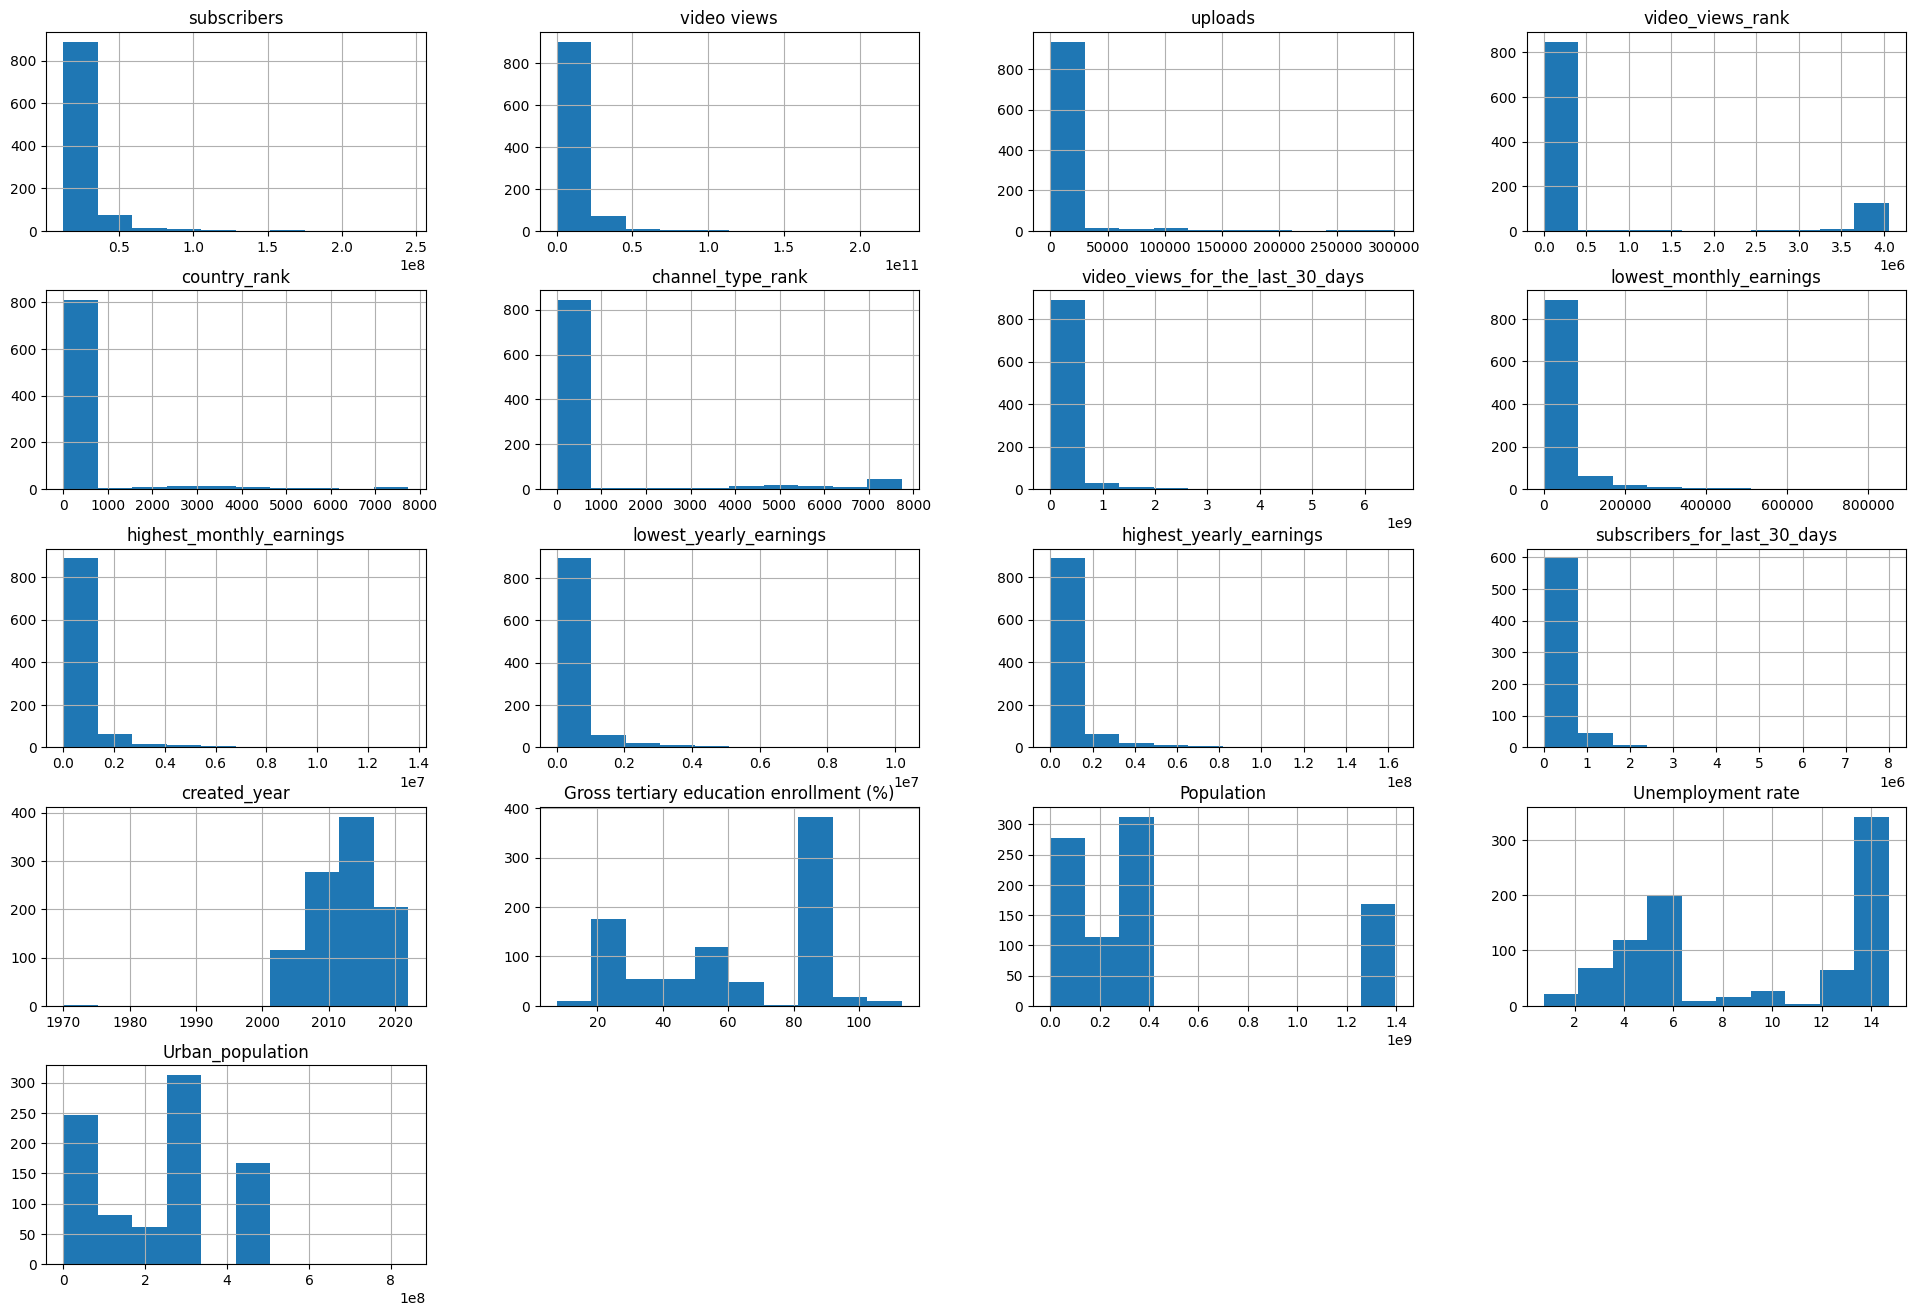

In [132]:
youtube_data.hist(figsize=(24, 16))


In [133]:
# As we can see from histogram Created Year has a wrong value so before moving on we will address that issue
youtube_data.drop(youtube_data.loc[youtube_data['created_year'] == 1970].index, inplace=True)

2) Correlation with regard to our target

In [134]:
corr_matrix = youtube_data.corr(numeric_only=True)
corr_matrix["subscribers"].sort_values(ascending=False)

subscribers                                1.000000
video views                                0.751734
lowest_yearly_earnings                     0.389560
lowest_monthly_earnings                    0.389428
highest_yearly_earnings                    0.389424
highest_monthly_earnings                   0.389067
subscribers_for_last_30_days               0.309719
video_views_for_the_last_30_days           0.279255
Urban_population                           0.083292
Population                                 0.082435
uploads                                    0.077350
video_views_rank                           0.057533
country_rank                               0.032943
channel_type_rank                          0.027708
Gross tertiary education enrollment (%)   -0.007625
Unemployment rate                         -0.009221
created_year                              -0.141156
Name: subscribers, dtype: float64

3) Visualizing different coorelation

Text(0, 0.5, 'subscribers')

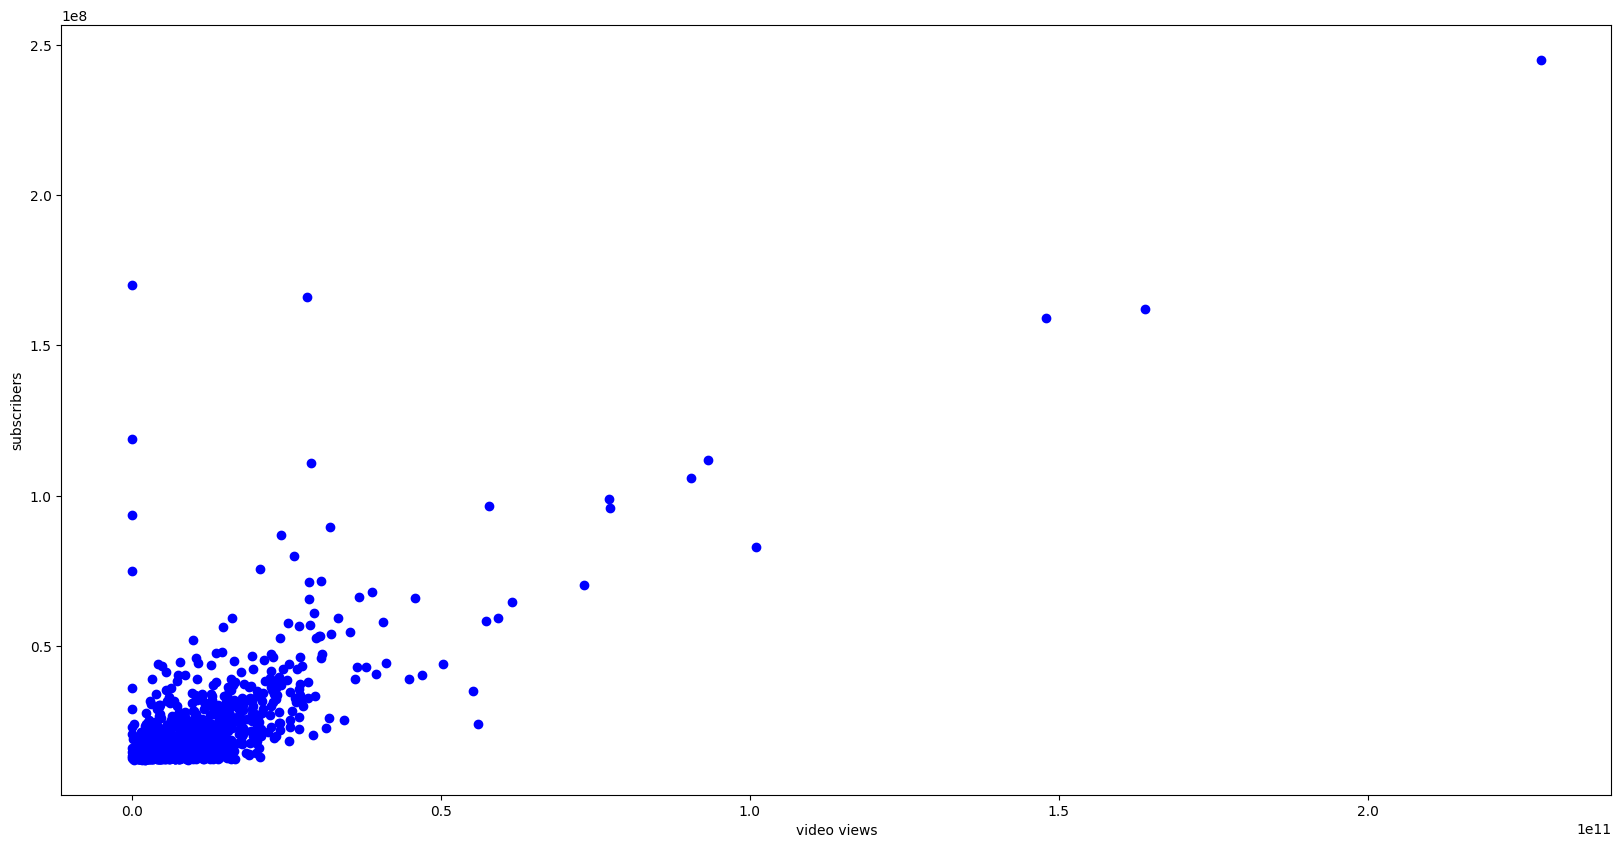

In [135]:
# Scatter Plot to show correlation between video views and subscribers
X = youtube_data["video views"]
y = youtube_data["subscribers"]
# Plot points
fig, pl = plt.subplots(figsize=(20, 10))
pl.scatter(X, y, color = 'b')
plt.xlabel("video views")
plt.ylabel("subscribers")


Text(0, 0.5, 'subscribers')

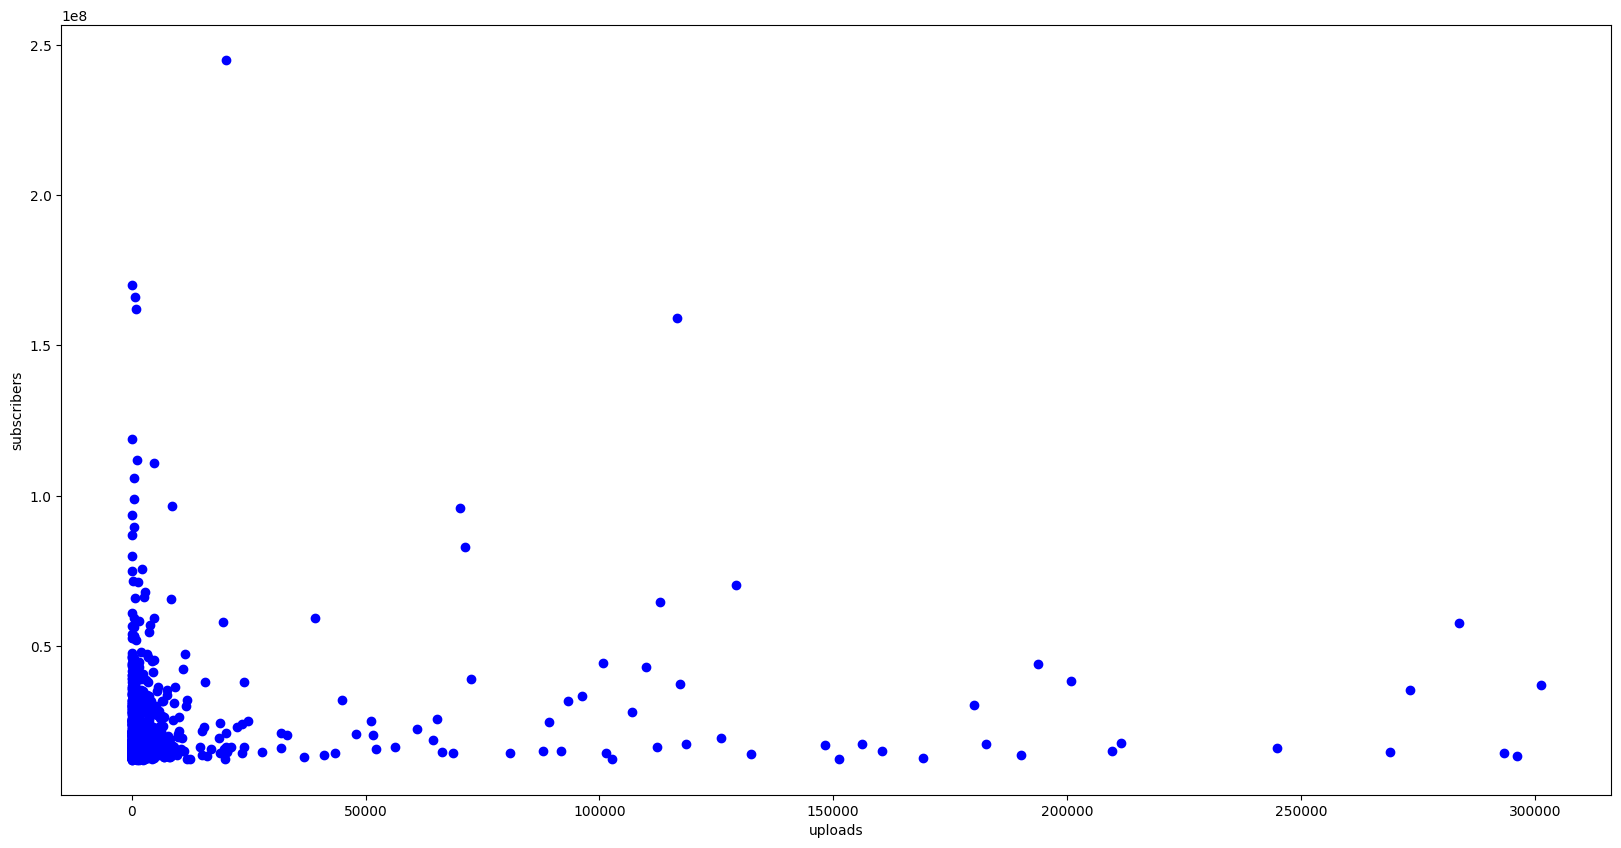

In [136]:
# Scatter Plot to show correlation between uploads and subscribers
X = youtube_data["uploads"]
y = youtube_data["subscribers"]
# Plot points
fig, pl = plt.subplots(figsize=(20, 10))
pl.scatter(X, y, color = 'b')
plt.xlabel("uploads")
plt.ylabel("subscribers")


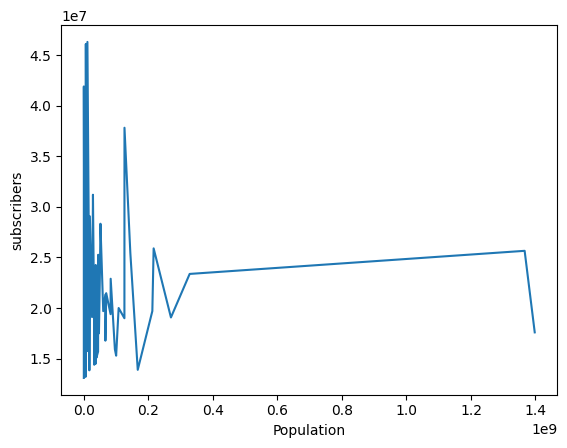

In [137]:
# Line Graph between population and subscribers
PopulationVsSubscribers = sns.lineplot(x="Population", y="subscribers", data=youtube_data, errorbar=None)

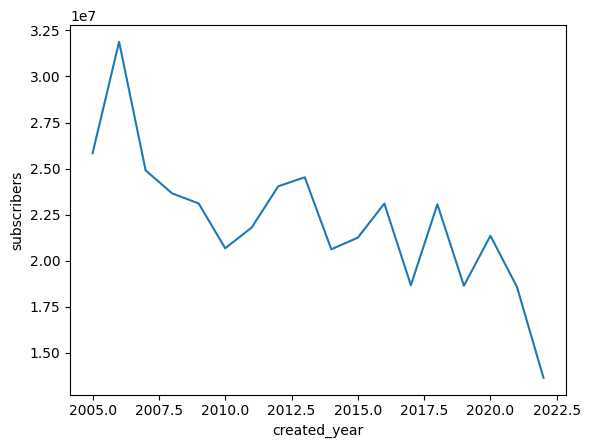

In [138]:
# Line Graph between year channel was created and subscribers
CreatedYearVsSubscribers = sns.lineplot(x="created_year", y="subscribers", data=youtube_data, errorbar=None)

# 4. Preparing the data for Machine Learning Algorithms

In [139]:
#Pipeline the data so that we can remove duplicate rows and fill empty values

#Duplicate entries in the code
print("Data Duplicates before transformation pipelines:")
duplicates = youtube_data.duplicated().sum() #Expected 0
print(duplicates)
#Just in case we do have duplicates

if(youtube_data.duplicated().sum() > 0):
    youtube_data.drop_duplicates(inplace=True)


# Assuming youtube_data is your DataFrame

# Find the number of missing entries in the dataset
missing_values = youtube_data.isna().sum()
print("\nMissing Values Before: ")
print(missing_values)


Data Duplicates before transformation pipelines:
0

Missing Values Before: 
subscribers                                  0
video views                                  0
category                                    46
uploads                                      0
video_views_rank                             1
country_rank                               116
channel_type_rank                           33
video_views_for_the_last_30_days            56
lowest_monthly_earnings                      0
highest_monthly_earnings                     0
lowest_yearly_earnings                       0
highest_yearly_earnings                      0
subscribers_for_last_30_days               337
created_year                                 5
Gross tertiary education enrollment (%)    123
Population                                 123
Unemployment rate                          123
Urban_population                           123
dtype: int64


In [140]:
# Scaling target column to get cleaner results from the models
youtube_data['subscribers_scaled by 1,000,000'] = youtube_data['subscribers'] / 1_000_000
youtube_data.drop('subscribers', axis=1, inplace=True)
youtube_data.head()

,video views,category,uploads,video_views_rank,country_rank,channel_type_rank,video_views_for_the_last_30_days,lowest_monthly_earnings,highest_monthly_earnings,lowest_yearly_earnings,highest_yearly_earnings,subscribers_for_last_30_days,created_year,Gross tertiary education enrollment (%),Population,Unemployment rate,Urban_population,"subscribers_scaled by 1,000,000"
0,2.280000e+11,Music,20082,1.0,1.0,1.0,2.258000e+09,564600.0,9000000.00,6800000.00,1.084000e+08,2000000.0,2006.0,28.1,1.366418e+09,5.36,471031528.0,245.0
1,0.000000e+00,Film & Animation,1,4055159.0,7670.0,7423.0,1.200000e+01,0.0,0.05,0.04,5.800000e-01,NaN,2006.0,88.2,3.282395e+08,14.70,270663028.0,170.0
2,2.836884e+10,Entertainment,741,48.0,1.0,1.0,1.348000e+09,337000.0,5400000.00,4000000.00,6.470000e+07,8000000.0,2012.0,88.2,3.282395e+08,14.70,270663028.0,166.0
3,1.640000e+11,Education,966,2.0,2.0,1.0,1.975000e+09,493800.0,7900000.00,5900000.00,9.480000e+07,1000000.0,2006.0,88.2,3.282395e+08,14.70,270663028.0,162.0
4,1.480000e+11,Shows,116536,3.0,2.0,2.0,1.824000e+09,455900.0,7300000.00,5500000.00,8.750000e+07,1000000.0,2006.0,28.1,1.366418e+09,5.36,471031528.0,159.0


In [174]:
# Split the dataset into number features and categorical features
num_cols = youtube_data.select_dtypes(include='number').columns.to_list()
cat_cols = youtube_data.select_dtypes(exclude='number').columns.to_list()
num_cols.remove("subscribers_scaled by 1,000,000")

# Create pipelines for numeric and categorical columns
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(sparse=False))


# Set the estimators
preprocessing = ColumnTransformer([('num',num_pipeline, num_cols),
                                   ('cat',cat_pipeline, cat_cols)],
                                    remainder='passthrough')

preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['video views', 'uploads', 'video_views_rank',
                                  'country_rank', 'channel_type_rank',
                                  'video_views_for_the_last_30_days',
                                  'lowest_monthly_earnings',
                                  'highest_monthly_earnings',
                                  'lowest_yearly_earnings',
                                  'highest_yearly_earnings',
                                  'subscribers_for_last_30_days',
                                  'created_year',
                                  'Gross tertiary education enrollment (%)',
                                  'Population', 'Unemployment rate',
                                  'Urban_population']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse=False))]),
                                 ['category'])])

In [175]:
# Running our data through the pipeline
youtube_prepped = preprocessing.fit_transform(youtube_data)

# # # Concatenating the feature names for our prepped data

feature_names=preprocessing.get_feature_names_out()
youtube_prepped = pd.DataFrame(data=youtube_prepped, columns=feature_names)


print(youtube_prepped.shape)
youtube_prepped.head()

(994, 35)


c:\Users\user\Desktop\PYTHON\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,num__video views,num__uploads,num__video_views_rank,num__country_rank,num__channel_type_rank,num__video_views_for_the_last_30_days,num__lowest_monthly_earnings,num__highest_monthly_earnings,num__lowest_yearly_earnings,num__highest_yearly_earnings,...,cat__category_News & Politics,cat__category_Nonprofits & Activism,cat__category_People & Blogs,cat__category_Pets & Animals,cat__category_Science & Technology,cat__category_Shows,cat__category_Sports,cat__category_Trailers,cat__category_Travel & Events,"remainder__subscribers_scaled by 1,000,000"
0,15.377376,0.318778,-0.407349,-0.332847,-0.389963,5.148295,7.344041,7.322252,7.382562,7.343749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,245.0
1,-0.783044,-0.269240,2.570041,6.289442,3.492458,-0.434603,-0.513807,-0.513984,-0.514019,-0.513779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0
2,1.227712,-0.247571,-0.407315,-0.332847,-0.389963,2.898323,4.176407,4.187758,4.131028,4.176092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,166.0
3,10.841118,-0.240982,-0.407348,-0.331984,-0.389963,4.448578,6.358679,6.364490,6.337426,6.357934,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,162.0
4,9.707053,3.143175,-0.407348,-0.331984,-0.389440,4.075231,5.831203,5.842074,5.872921,5.828783,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,159.0


In [177]:
# # Double Checking if all missing features have been taken care of
missing_values = youtube_prepped.isna().sum()
print("\nMissing Values After: ")
missing_values


Missing Values After: 


num__video views                                0
num__uploads                                    0
num__video_views_rank                           0
num__country_rank                               0
num__channel_type_rank                          0
num__video_views_for_the_last_30_days           0
num__lowest_monthly_earnings                    0
num__highest_monthly_earnings                   0
num__lowest_yearly_earnings                     0
num__highest_yearly_earnings                    0
num__subscribers_for_last_30_days               0
num__created_year                               0
num__Gross tertiary education enrollment (%)    0
num__Population                                 0
num__Unemployment rate                          0
num__Urban_population                           0
cat__category_Autos & Vehicles                  0
cat__category_Comedy                            0
cat__category_Education                         0
cat__category_Entertainment                     0


In [178]:
#Split the Dataset into 80% for training and 20% for testing

X = youtube_prepped.drop(['remainder__subscribers_scaled by 1,000,000'], axis=1)
y = youtube_prepped['remainder__subscribers_scaled by 1,000,000']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)



(795, 34) (795,) (199, 34) (199,)


#Step 5: Training Machine Learning Algorithms

1) Linear Regression

In [179]:
# Training the model with Linear Regression
lr_model = LinearRegression()

lr_model.fit(X_train,y_train)



LinearRegression()

In [146]:
# Testing the model on test set and reporting Mean Absolute Error
lr_y_predict = lr_model.predict(X_test)


lr_mae = mae(y_test, lr_y_predict)

print(lr_mae)



5.996229635859799


2) Lasso Regression

In [147]:
# Training the model with Lasso Regression

LassoRegression = Lasso(alpha=1)
lasso_model = LassoRegression.fit(X_train, y_train)

In [148]:
# Testing the model on test set and reporting Mean Absolute Error
Lasso_y_predict = lasso_model.predict(X_test)

lasso_mae = mae(y_test, Lasso_y_predict)

print(f'Lasso Regression MAE: {lasso_mae}')

Lasso Regression MAE: 6.035042692473218


3) Polynomial with Ridge Regularization

In [149]:
# add new features according to the Polynomial degree
poly = PolynomialFeatures(degree= 2)
X_train_trans = poly.fit_transform(X_train)
X_test_trans = poly.transform(X_test)

In [150]:
# train the ridge model with the new features

RidgeRegression = Ridge(alpha=3)
ridge_model = RidgeRegression.fit(X_train_trans, y_train)


In [151]:
# Testing the model on test set and reporting Mean Absolute Error

ridge_scores = cross_val_score(ridge_model, X_train_trans, y_train, cv=5, scoring='neg_mean_absolute_error')

mean_score = -ridge_scores.mean()  # Take the negative value to get the mean squared error

print(f'Cross-Validation Mean Score: {mean_score}')



Cross-Validation Mean Score: 8.954167195216774


#6 Graphs for the Best performing algorithms


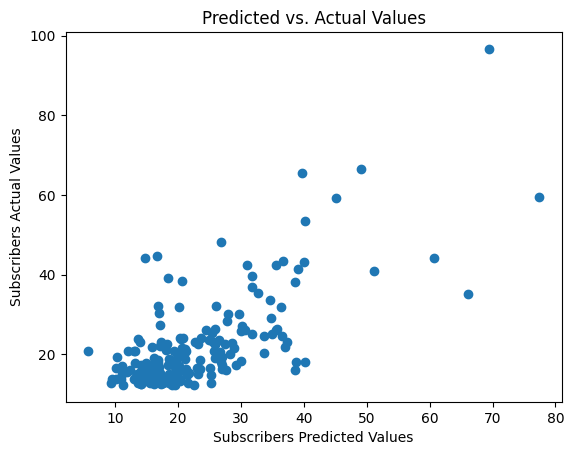

In [152]:
#Linear Regression Model Graph
plt.scatter(lr_y_predict, y_test)  # y is your actual target values
plt.xlabel("Subscribers Predicted Values")
plt.ylabel("Subscribers Actual Values")
plt.title("Predicted vs. Actual Values")
plt.show()

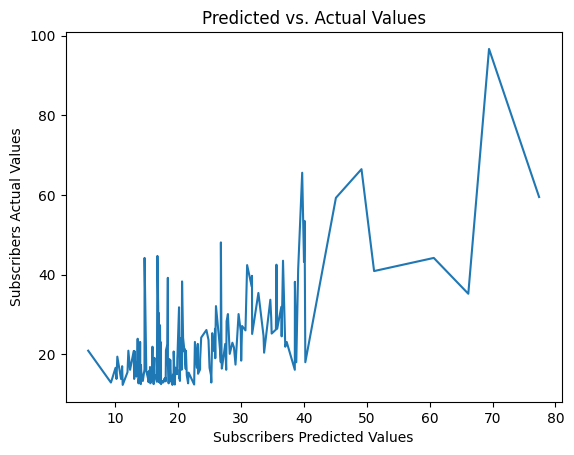

In [153]:


X = lr_y_predict
Y = y_test
sns.lineplot(x=X, y=Y, errorbar=None)
plt.xlabel('Subscribers Predicted Values')
plt.ylabel('Subscribers Actual Values')
plt.title('Predicted vs. Actual Values')

# Show the plot
plt.show()



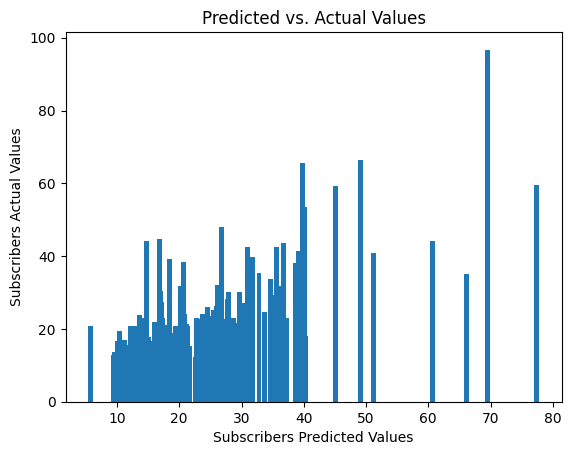

In [154]:
#Linear Regression Model Graph
plt.bar(lr_y_predict, y_test)  # y is your actual target values
plt.xlabel("Subscribers Predicted Values")
plt.ylabel("Subscribers Actual Values")
plt.title("Predicted vs. Actual Values")
plt.show()

# Create a Model File

In [155]:
import pickle

#Create a new pickle file in the working directory 
pkl_filename = "Linear_Reg_Model.pkl"

#Add our linear_regression model in it 
with open(pkl_filename, 'wb') as file:
    pickle.dump(lr_model, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
# Calculate the mae score and predict target values

# Testing the model on test set and reporting Mean Absolute Error
pkl_y_predict = pickle_model.predict(X_test)
pkl_mae = mae(y_test, pkl_y_predict)
pkl_mae

5.996229635859799

# Making sure it works with a test sample (Predictor)

In [191]:
# This is going to be for loading a data frame in and sending it through our pkl model 
def predict_mpg(config, model):
    ##loading the model from the saved file
  
    if type == dict: 
        df = pd.DataFrame(config)

    else: 
        df = config

    y_pred = model.predict(df) 
    result = y_pred[0] if len(y_pred) > 0 else None

    return result
  

In [196]:
config_dict = {
    'num_video views': 10000000,
    'num_uploads': 47,
    'num_video_views_rank': 6271,
    'num_country_rank': 3,
    'num_channel_type_rank': 700,
    'num_video_views_for_the_last_30_days': 100,
    'num_lowest_monthly_earnings': 782.1,
    'num_highest_monthly_earnings': 9000.9,
    'num_lowest_yearly_earnings': 800,
    'num_highest_yearly_earnings': 10000,
    'num_subscribers_for_last_30_days': 600001,
    'num_created_year': 2019,
    'num_Gross tertiary education enrollment (%)': 29,
    'num_Population': 5000000,
    'num_Unemployment rate': 7.12,
    'num_Urban_population': 374000000,
    'cat_category_Autos & Vehicles': 1,
    'cat_category_Comedy': 0,
    'cat_category_Education': 0,
    'cat_category_Entertainment': 0,
    'cat_category_Film & Animation': 0,
    'cat_category_Gaming': 0,
    'cat_category_Howto & Style': 0,
    'cat_category_Movies': 0,
    'cat_category_Music': 0,
    'cat_category_News & Politics': 0,
    'cat_category_Nonprofits & Activism': 0,
    'cat_category_People & Blogs': 0,
    'cat_category_Pets & Animals': 0,
    'cat_category_Science & Technology': 0,
    'cat_category_Shows': 0,
    'cat_category_Sports': 0,
    'cat_category_Trailers': 0,
    'cat_category_Travel & Events': 0
}

import numpy as np

# Convert the values of the dictionary into a 1D array
config_array = np.array(list(config_dict.values()))

# Use the shape attribute to convert it into a 2D array
# Reshape the 1D array into a 2D array with one row and the number of columns
config_2d_array = config_array.reshape(1, -1)

# Print the resulting 2D array
# print(config_2d_array)

result = predict_mpg(config=config_2d_array, model=lr_model)
print(f'subscribers: {result}')




subscribers: 912396598.3210268


c:\Users\user\Desktop\PYTHON\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
